# Difference in Differences with `pymc` models

:::{note}
This example is in-progress! Further elaboration and explanation will follow soon.
:::

In [1]:
import arviz as az

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = cp.load_data("did")
df.head()

,group,t,unit,post_treatment,y
0,0,0.0,0,False,0.897122
1,0,1.0,0,True,1.961214
2,1,0.0,1,False,1.233525
3,1,1.0,1,True,2.752794
4,0,0.0,2,False,1.149207


## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


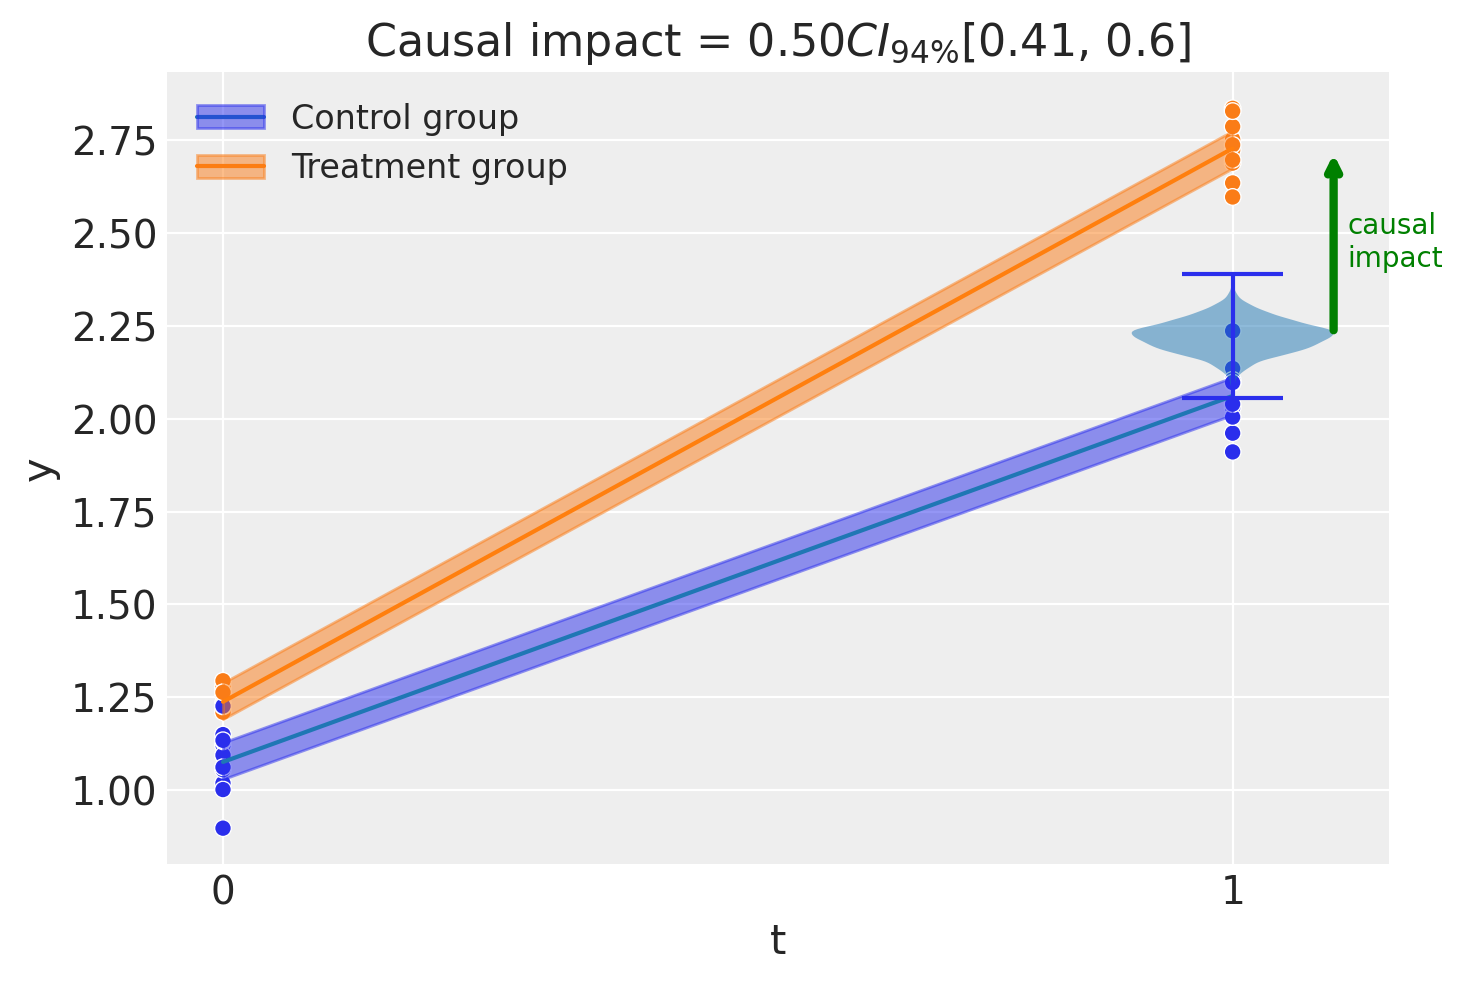

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

===========================Difference in Differences============================
Formula: y ~ 1 + group*post_treatment

Results:
Causal impact = 0.50$CI_{94\%}$[0.41, 0.6]
Model coefficients:
    Intercept                     1.1, 94% HDI [1, 1.1]
    post_treatment[T.True]        0.99, 94% HDI [0.92, 1.1]
    group                         0.16, 94% HDI [0.092, 0.23]
    group:post_treatment[T.True]  0.5, 94% HDI [0.41, 0.6]
    y_hat_sigma                   0.082, 94% HDI [0.066, 0.1]


We can get nicely formatted tables from our integration with the [maketables](https://github.com/py-econometrics/maketables) package.

In [17]:
from maketables import ETable

result.set_maketables_options(hdi_prob=0.95)
ETable(result, coef_fmt="b:.3f \n [ci95l:.3f, ci95u:.3f]")

<maketables.mtable.MTable.__repr__.<locals>.DualOutput at 0x171de9be0>

In [8]:
ax = az.plot_posterior(result.causal_impact, ref_val=0)
ax.set(title="Posterior estimate of causal impact");

## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics. Note that for Difference-in-Differences, the effect is a single scalar (average treatment effect), unlike time-series experiments where effects vary over time.


In [9]:
# Generate effect summary
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0
treatment_effect,0.504728,0.503797,0.398865,0.605905,1.0


In [10]:
print(stats.text)

The average treatment effect was 0.50 (95% HDI [0.40, 0.61]), with a posterior probability of an increase of 1.000.


You can customize the summary with different directions and ROPE thresholds:

- **Direction**: Test for increase, decrease, or two-sided effect
- **Alpha**: Set the HDI confidence level (default 95%)
- **ROPE**: Specify a minimal effect size threshold


In [11]:
# Example: Two-sided test with ROPE
stats = result.effect_summary(
    direction="two-sided",
    alpha=0.05,
    min_effect=0.3,  # Region of Practical Equivalence
)
stats.table

,mean,median,hdi_lower,hdi_upper,p_two_sided,prob_of_effect,p_rope
treatment_effect,0.504728,0.503797,0.398865,0.605905,0.0,1.0,0.9995


In [12]:
print("\n" + stats.text)


The average treatment effect was 0.50 (95% HDI [0.40, 0.61]), with a posterior probability of an effect of 1.000.
